In this tutorial we program and use the k-means algorithm to classify a population of 3D voids obtained by X-ray tomography. Thanks to Hugo Launay, Laurent Lacourt and David Ryckelynck for sharing the data set.

In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt, matplotlib.cm as cm

# Data pre-processing

Start by loading the complete data set into memory, the data is stored into a compressed numpy array and can be loaded simply using `np.load`

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import os
path = "/content/drive/My Drive"

os.chdir(path)
os.listdir(path)
#import sys
#print(sys.version)


['rapport TN09',
 'carte ID',
 'P16',
 'A16',
 'Le blues du bandit 3.mp3',
 'Projet',
 'Lettre recommandation',
 'BigDataFormation',
 'deblending (1)',
 'morphology',
 'star-galaxy',
 'sizes',
 'Colab Notebooks',
 'deblending',
 'UIJLZQ-HUGO-LAUNAY.pdf',
 'swimrun2k20',
 'PM_TP',
 'Classification de défauts pour la réduction de modèles mécaniques.docx',
 'Auto-encodeur-de-defauts',
 'compo.m4a',
 'TP_PONT',
 'ADRIEN_EXCEL.gsheet',
 'defect32.raw',
 'image_stock.npy']

In [18]:
import numpy as np
data=np.load('image_stock.npy')

Look how many data points we have

In [19]:
print(len(data))

4417


In [20]:
# observe that each data point is a numpy array of size (40 x 40 x 40) in binary form (either 0 or 1)
print(np.shape(data[0]))
print(np.unique(data))

(40, 40, 40)
[0 1]


At this point, it is useful to hava a look at the data. We will do this by plotting randomly a few voids in 2D (summing up the third dimension)

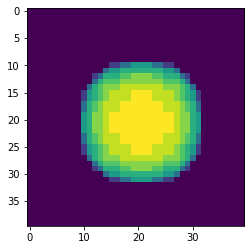

In [21]:
plt.imshow(np.sum(data[0], axis=2))

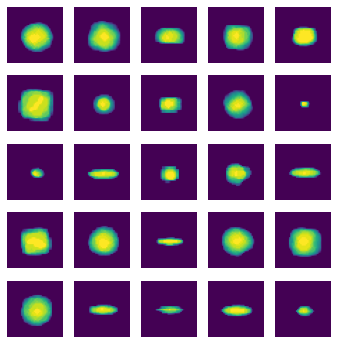

In [22]:
n = 5
plt.figure(figsize=(n, n))
for j in range(n):
    for i in range(n):
        index = n * j + i
        axi = plt.subplot(n, n, index + 1)
        axi.imshow(np.sum(data[np.random.randint(4417)].T, axis=2))
        axi.axis('off')
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.04, top=0.96)
plt.show()

Now we have a better understanding of the natude of the data, we will compute some features: **volume** and **sphericity**

The volume (in voxels) can be simply computed by summing all voxels that equals 1. As other voxels equals 0, we can simply sum all voxels.

$V_i=\sum_{v\in data[i]}v$

In [23]:
volumes = np.sum(data, axis=(1, 2, 3))
print(volumes.shape)

(4417,)


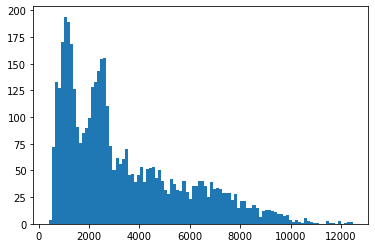

In [24]:
plt.hist(volumes, bins=100)
plt.show()

The sphericity measures how close to a sphere is a given void (or particle). It can be computed by the ratio between the ideal surface area and the actual surface area of that void $A_i$. The ideal surface area is the surface area of a sphere with the same volume.

$\psi_i = \dfrac{\pi^{1/3}(6V_i)^{2/3}}{A_i}$

To compute the surface area of each void we will simply count each voxel on the surface. This can be done by a simple erosion operation.

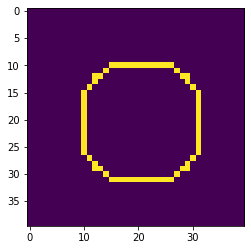

In [25]:
from scipy.ndimage.morphology import binary_erosion

surface = data[0] - binary_erosion(data[0])
plt.imshow(surface[:, :, 20].T)

In [26]:
surface_areas = [np.sum(data[i] - binary_erosion(data[i])) for i in range(4417)]

In [27]:
sphericities = np.pi ** (1/3) * (6 * volumes) ** (2/3) / surface_areas

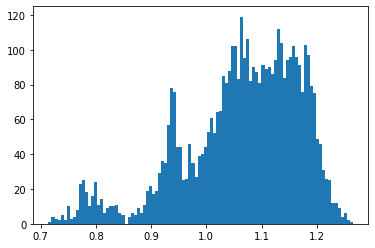

In [28]:
plt.hist(sphericities, bins=100)
plt.show()

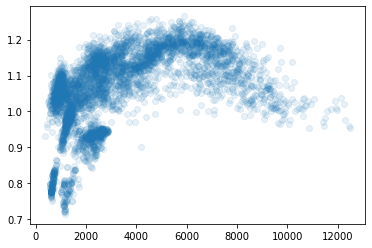

In [29]:
plt.plot(volumes, sphericities, 'o', alpha=0.1)

## data normalization

This is a good example where we will have to normalize the data so that both volume and sphericity have the same weigth in the distance calculation.

In [33]:
volumes_norm = (volumes - volumes.min()) / (volumes.max() - volumes.min())

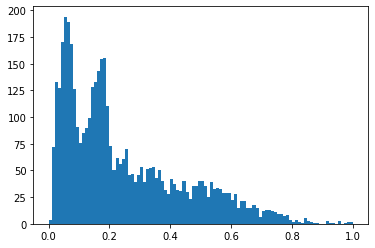

In [34]:
plt.hist(volumes_norm, bins=100)
plt.show()

In [35]:
sphericities_norm = (sphericities - sphericities.min()) / (sphericities.max() - sphericities.min())

# K-means algorithm

In the K-means algorithm, the number of classes is fixed (it is a hyper-parameter)

In [36]:
K = 5  # number of classes
void_data = np.vstack([volumes_norm, sphericities_norm]).T
print(void_data.shape)
n = len(void_data)  # number of data points
distances= np.zeros(K)  # an array to compute the distance to all centroids for a given point

(4417, 2)


In [37]:
labels = np.zeros(n, dtype=np.uint8)

In [38]:
# picks the initial centroids randomly
centroid_indices = np.random.permutation(n)[:K]
centroids = void_data[centroid_indices]
print(centroids.shape)

(5, 2)


create a function to compute the labels for all the data points given the centroids

In [39]:
def compute_labels():
    """compute the labels for all the data points given the centroids."""
    for i in range(n):
        # compute the distance with each centroid for this data point
        for k in range(K):
            distances[k] = np.linalg.norm(void_data[i] - centroids[k])
        labels[i] = np.argmin(distances)

create a function to compute the $K$ centroids points given the labels

In [40]:
def compute_centroids():
    """compute the new centroids given the labels."""
    for k in range(K):
        # get all the point in cluster k and average them
        centroids[k] = np.average(void_data[labels == k], axis=0)

Now run the algorithm: at each step we compute the labels (given the centroids) and then compute the centroids (given the labels). We stop when the centroids did not change with respect to the previous iteration or if we reach a maximum number of iterations.

In [41]:
# run the K-means algorithm
max_iter = 50
iter = 1

previous_centroids = centroids.copy()
compute_labels()
compute_centroids()

while not np.array_equal(centroids, previous_centroids) and iter <= max_iter:
    print('K-means iteration %d' % iter)
    previous_centroids = centroids.copy()
    compute_labels()
    compute_centroids()
    iter += 1

print('done')

K-means iteration 1
K-means iteration 2
K-means iteration 3
K-means iteration 4
K-means iteration 5
K-means iteration 6
K-means iteration 7
K-means iteration 8
K-means iteration 9
K-means iteration 10
K-means iteration 11
K-means iteration 12
K-means iteration 13
K-means iteration 14
K-means iteration 15
K-means iteration 16
K-means iteration 17
K-means iteration 18
done


In [42]:
centroids

array([[0.6702631 , 0.65010789],
       [0.23174645, 0.75467419],
       [0.108036  , 0.31316021],
       [0.0872518 , 0.59124724],
       [0.45607259, 0.8403075 ]])

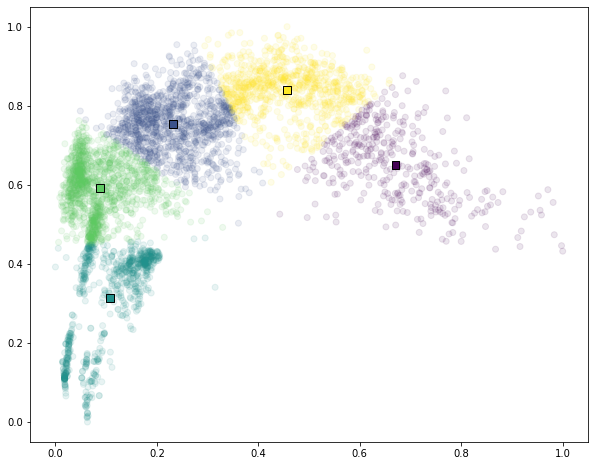

In [43]:
plt.figure(figsize=(10, 8))
plt.scatter(volumes_norm, sphericities_norm, c=labels, alpha=0.1)
plt.scatter(centroids[:, 0], centroids[:, 1], c=range(K), marker='s', edgecolors='k', s=60)
#plt.scatter(void_data[representants][:, 0], void_data[representants][:, 1], c=range(K), marker='o', edgecolors='k', s=60)

## plot a representant of each class

In [44]:
# find the closest data point to each class
representants = np.empty(K, dtype=int)
all_distances = np.zeros(n)

for k in range(K):
    for i in range(n):
        all_distances[i] = np.linalg.norm(void_data[i] - centroids[k])
    representants[k] = np.argmin(all_distances)
print(representants)

[1074  410 3783  599  511]


In [45]:
void_data[representants]

array([[0.67419729, 0.65154617],
       [0.23047004, 0.75520911],
       [0.1030288 , 0.3185168 ],
       [0.0877193 , 0.58938367],
       [0.46011255, 0.84458787]])

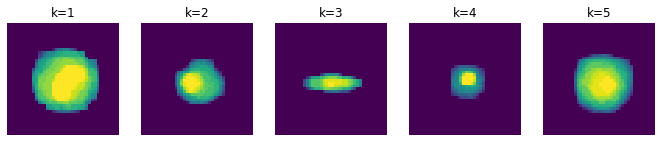

In [46]:
plt.figure(figsize=(10, 2))
for k in range(K):
    ax = plt.subplot(1, K, k + 1)
    ax.imshow(np.sum(data[representants[k]].T, axis=2), interpolation='nearest')
    ax.axis('off')
    ax.set_title('k=%d' % (k + 1))
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.04, top=0.96)
plt.show()

## bonus: plotting the voids in 3D

In [47]:
l = 40
x, y, z = np.mgrid[0:l, 0:l, 0:l]
data_ = np.indices((l, l, l))[0] * np.indices((l, l, l))[1] * np.indices((l, l, l))[2]
data_ = data_ / np.max(data_.astype(float))
alpha = 1.
colors = plt.cm.cool(data_) * [1, 1, 1, alpha]

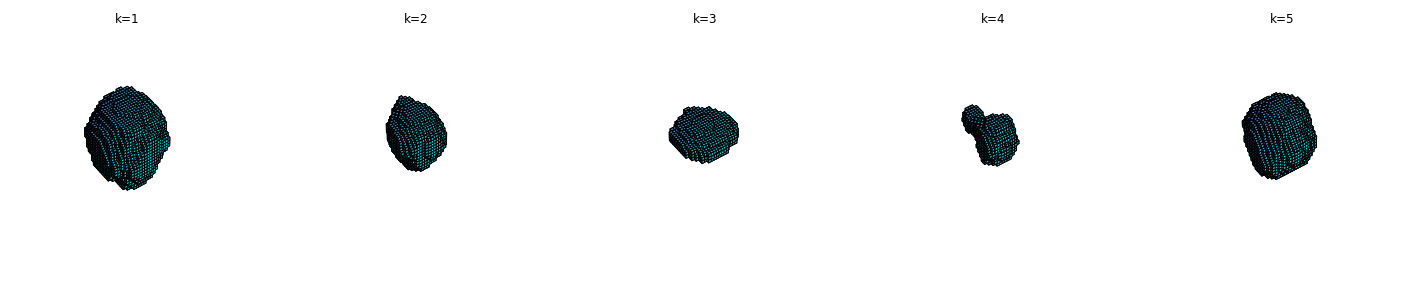

In [48]:
fig = plt.figure(figsize=(K * 5, 5))
for k in range(K):
    ax = fig.add_subplot(1, K, k + 1, projection='3d')
    ax.voxels(data[representants[k]], facecolors=colors, edgecolor='k')
    ax.view_init(elev=40., azim=145)
    ax.grid(False)
    ax.set_title('k=%d' % (k + 1))
    plt.axis('tight')
    plt.axis('off')
plt.show()

# Using K-means with scikit-learn

Here you will find the code to use K-means with the popular machine learning package scikit-learn. You are encouraged to learn to use this package altough writting code yourself is always a good exercice.

In [49]:
from sklearn.cluster import KMeans

In [50]:
kmeans = KMeans(n_clusters=K, random_state=42).fit(void_data)

In [51]:
y = kmeans.fit_predict(void_data)

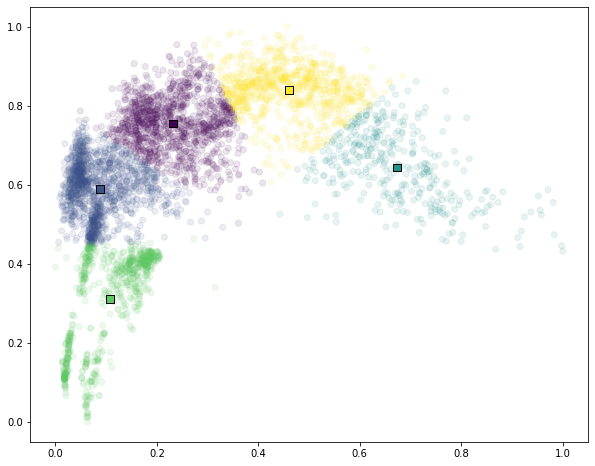

In [52]:
plt.figure(figsize=(10, 8))
plt.scatter(volumes_norm, sphericities_norm, c=y, alpha=0.1)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c=range(K), marker='s', edgecolors='k', s=60)